<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Проверим-распределение-классов" data-toc-modified-id="Проверим-распределение-классов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Проверим распределение классов</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span><strong>Вывод:</strong></a></span></li></ul></li><li><span><a href="#Очистка-текста-и-лемматизация-Wordnet--Lemmatizer-с--POS-тегом" data-toc-modified-id="Очистка-текста-и-лемматизация-Wordnet--Lemmatizer-с--POS-тегом-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Очистка текста и лемматизация Wordnet  Lemmatizer с  POS-тегом</a></span></li><li><span><a href="#Создание-выборок" data-toc-modified-id="Создание-выборок-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Создание выборок</a></span></li><li><span><a href="#TF-IDF-и-создание-выборок" data-toc-modified-id="TF-IDF-и-создание-выборок-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>TF-IDF и создание выборок</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span><strong>Вывод:</strong></a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><strong>LogisticRegression</strong></a></span></li><li><span><a href="#LinearSVC" data-toc-modified-id="LinearSVC-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><strong>LinearSVC</strong></a></span></li><li><span><a href="#Тест" data-toc-modified-id="Тест-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span><strong>Тест</strong></a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span><strong>Вывод:</strong></a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.



**Описание данных**

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import warnings

from pymystem3 import Mystem
from tqdm.notebook import tqdm

import optuna 
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import RegexpTokenizer
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.utils import shuffle

warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
 
RS=12345    

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df = df.drop(['Unnamed: 0'], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


### Проверим распределение классов 

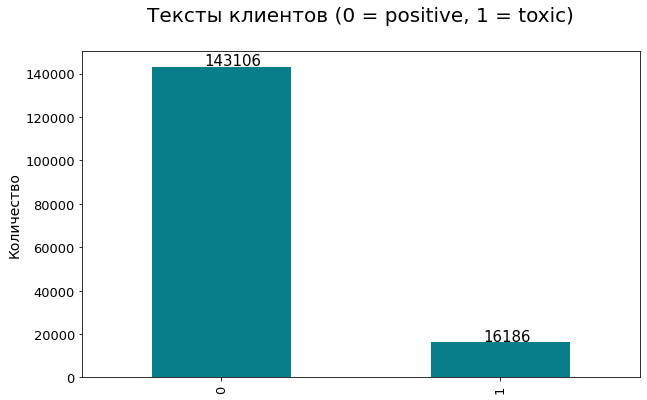

In [7]:
ax = df['toxic'].value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='#087E8B')
ax.set_title('Тексты клиентов (0 = positive, 1 = toxiс)', size=20, pad=30)
ax.set_ylabel('Количество', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=15)

#### **Вывод:**

Имеется явный дисбаланс классов:
- **положительных ≈90%** 
- **отрицательных ≈10%**

Попробуем достичь условия(**F1>75**) на имеющихся данных, без ресемплирования

### Очистка текста и лемматизация Wordnet  Lemmatizer с  POS-тегом

In [8]:
def clear_text(text):
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    c_text = ' '.join(text.split())
    return c_text

In [9]:
df['text'] = df['text'].apply(clear_text)

In [10]:
df.head()

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D'aww He matches this background colour I'm se...,0
2,Hey man I'm really not trying to edit war It's...,0
3,More I can't make any real suggestions on impr...,0
4,You sir are my hero Any chance you remember wh...,0


In [11]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
lemmatizer = WordNetLemmatizer()

In [13]:
%%time

lemmatized_texts = []

    
for i, row in tqdm(df.iterrows()):
  
    text = row['text']
    tokenizer = RegexpTokenizer(r'\w+')
    # конвертируем строку в нижний регистр и разбиваем текст  на слова
    tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w 
              in tokenizer.tokenize(text.lower())]

    # отбрасываем числа, если они были в тексте и слова длины 1
    tokens = [token for token in tokens if
              (not token.isnumeric() and len(token) > 1)]
    lemmatized_texts.append(' '.join(tokens))
    
df['lemm_text'] = lemmatized_texts    

0it [00:00, ?it/s]

CPU times: user 20min 47s, sys: 2min, total: 22min 47s
Wall time: 23min 30s


In [14]:
df.head()

,text,toxic,lemm_text
0,Explanation Why the edits made under my userna...,0,explanation why the edits make under my userna...
1,D'aww He matches this background colour I'm se...,0,aww he match this background colour seemingly ...
2,Hey man I'm really not trying to edit war It's...,0,hey man really not try to edit war it just tha...
3,More I can't make any real suggestions on impr...,0,more can make any real suggestion on improveme...
4,You sir are my hero Any chance you remember wh...,0,you sir be my hero any chance you remember wha...


### Создание выборок

In [15]:
df = df.drop(['text'], axis=1)

In [16]:
df.head(10)

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,aww he match this background colour seemingly ...
2,0,hey man really not try to edit war it just tha...
3,0,more can make any real suggestion on improveme...
4,0,you sir be my hero any chance you remember wha...
5,0,congratulation from me well use the tool well ...
6,1,cocksucker before you piss around on my work
7,0,your vandalism to the matt shirvington article...
8,0,sorry if the word nonsense be offensive to you...
9,0,alignment on this subject and which be contrar...


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   toxic      159292 non-null  int64 
 1   lemm_text  159292 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [18]:
features = df.drop(['toxic'], axis=1)
target = df['toxic']


In [19]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.25, 
                                                                              random_state=RS,
                                                                              )

### TF-IDF и создание выборок 

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
stopwords = set(nltk_stopwords.words('english'))

In [22]:
type(stopwords)

set

In [23]:
stopwords = list(stopwords)

### **Вывод:**

1. Загружен датасет 

2. Проверено распределение классов и сделан вывод 

3. Проведена очистка текста и лемматизация Wordnet Lemmatizer с POS-тегом

4. Созданы выборки 

## Обучение

### **LogisticRegression**

In [24]:
%%time 




model_l = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
                    ('clf', LogisticRegression(random_state=RS))]
                   )
                   
   
               
parametres = {'clf__C': [10, 15]}  
                   
       
                   
scoring='f1'
n_jobs = -1

gr_lr = GridSearchCV(model_l,
                     param_grid = parametres,
                     scoring = scoring,
                     n_jobs = n_jobs,
                     verbose=3,
                     cv=3,
                     refit=False).fit(features_train['lemm_text'], target_train)
                               
display(gr_lr.best_params_)
display(gr_lr.best_score_)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END ......................................clf__C=10; total time=  47.7s
[CV 2/3] END ......................................clf__C=10; total time=  47.7s
[CV 3/3] END ......................................clf__C=10; total time=  48.3s
[CV 1/3] END ......................................clf__C=15; total time=  48.1s
[CV 2/3] END ......................................clf__C=15; total time=  50.4s
[CV 3/3] END ......................................clf__C=15; total time=  47.5s


{'clf__C': 10}

0.7617829174649122

CPU times: user 2min 26s, sys: 2min 22s, total: 4min 48s
Wall time: 4min 49s


### **LinearSVC**

In [26]:
%%time 




model_svc = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
                    ('clf', LinearSVC())])
                   
   
               
parametres = {'clf__C': [5, 10]}  
                   
       
                   
scoring='f1'
n_jobs = -1

gr_svc = GridSearchCV(model_svc,
                     param_grid = parametres,
                     scoring = scoring,
                     n_jobs = n_jobs,
                     verbose=3,
                     cv=3,
                     refit=False).fit(features_train['lemm_text'], target_train)
                               
display(gr_svc.best_params_)
display(gr_svc.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END .......................................clf__C=5; total time=   7.4s
[CV 2/3] END .......................................clf__C=5; total time=   7.7s
[CV 3/3] END .......................................clf__C=5; total time=   8.6s
[CV 1/3] END ......................................clf__C=10; total time=   9.3s
[CV 2/3] END ......................................clf__C=10; total time=   8.9s
[CV 3/3] END ......................................clf__C=10; total time=   9.8s


{'clf__C': 5}

0.7487958727251387

CPU times: user 51.2 s, sys: 540 ms, total: 51.8 s
Wall time: 51.9 s


### **Тест**

Тестируем модель **LogisticRegression**

In [27]:
model_l.set_params(**gr_lr.best_params_) 
model_l.fit(features_train['lemm_text'], target_train) 
predictions = model_l.predict(features_test['lemm_text'])
f1 = f1_score(target_test, predictions)
print(f1)

0.783114186851211


### **Вывод:**

In [28]:
index = ['LogisticRegression']

metric = {
        'F1 Test':[0.783114186851211
                  ]}

sravnenie = pd.DataFrame(data=metric, index=index)
sravnenie['Выполнение задачи'] = sravnenie['F1 Test'] > 0.75
sravnenie

,F1 Test,Выполнение задачи
LogisticRegression,0.783114,True


Были обучены следующие модели:
- **LogisticRegression**
- **LinearSVC**

Наилучшей моделью оказалась **LogisticRegression**, показатель метрики **F1** на тестовой выборке - **0.783114**, что больше условия **>75**

## Общий вывод

1. Подготовка:

- Загружен датасет

- Проверено распределение классов и сделан вывод

- Проведена очистка текста и лемматизация Wordnet Lemmatizer с POS-тегом

- Созданы выборки 

2. Были обучены следующие модели с pipeline и TfidfVectorizer:

- LogisticRegression

- LinearSVC



Наилучшей моделью оказалась **LogisticRegression**, показатель метрики **F1** на тестовой выборке - **0.783114**, что больше условия **>75**

Задача выполнена!



